# Settings and importations

In [3]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.chunk import conlltags2tree, tree2conlltags
from nltk import download
import nltk
download("stopwords")
download('punkt')
download('averaged_perceptron_tagger')


import pickle
from re import match
import numpy as np
from scipy.stats import entropy

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


#Instructions

The goal of this lab is to disambiguate entities in a text. For example, given a Wikipedia article:

    <Paris_17>
    Paris is a figure in the Greek mythology.

the goal is to determine that `<Paris_17> = <Paris_(mythology)>`.
Here, `<Paris_17>` is an artificial title of the Wikipedia article, and `<Paris_(mythology)>` is the unambiguous entity in the YAGO knowledge base.
(https://yago-knowledge.org/graph/%22Paris%22@en?relation=all&inverse=1)

### === Provided Data ===

We provide:
1. a preprocessed version of the Simple Wikipedia wikipedia-ambiguous.txt, which contains ambiguous article titles with their content, as above.
2. a simplified version of the YAGO knowledge base.
3. a template for your code, disambiguator.py
4. a gold standard sample.

### === Task ===

Your task is to complete the function `disambiguate()` in this file.
It receives as input (1) the ambiguous Wikipedia title ("Paris" in the example), and (2) the article content.
The method shall return the unambiguous entity from YAGO.
In order to ensure a fair evaluation, do not use any non-standard Python libraries except `nltk`.
The lab will be graded by a variant of the F1 score that gives higher weight to precision (with `beta=0.5`).

Input:
`<Babilonia_0>`
Babilonia is a 1987 Argentine drama film directed and written by Jorge Salvador based on a play by Armando Discépolo.

Output:
`<Babilonia_0>`	TAB `<Babilonia>`

### === Development and Testing ===

**In YAGO, the entities have readable ids, as in <Ashok_Kumar_(British_politician)>. This is, however, not the case in all knowledge bases. Therefore, your algorithm should not rely on the suffix "British Politician"!**

To enforce this, we deliver two versions of the lab:
1) Development: With readable entity ids
The corresponding YAGO knowledge base is dev_yago.tsv, and the gold standard is dev_gold_samples.tsv
2) Testing: Without readable entity ids
The corresponding YAGO knowledge base is test_yago.tsv. Here, the British politician has the id <Ashok_Kumar_1081507>. This is the file that you will be evaluated on!

#Utils

In [4]:
"""
This cell contains the classes and functions that are used for reading and parsing the simplified knowledge base.
Don't modify this code.
"""
import sys


class Page:
    """
    This class is used to store title and content of a wiki page
    """
    __author__ = "Jonathan Lajus"

    def __init__(self, title, content):
        self.content = content
        self.title = title
        if sys.version_info[0] < 3:
            self.title = title.decode("utf-8")
            self.content = content.decode("utf-8")

    def __eq__(self, other):
        return isinstance(other, self.__class__) and self.title == other.title and self.content == other.content

    def __ne__(self, other):
        return not self.__eq__(other)

    def __hash__(self):
        return hash((self.title, self.content))

    def __str__(self):
        return 'Wikipedia page: "' + (self.title.encode("utf-8") if sys.version_info[0] < 3 else self.title) + '"'

    def __repr__(self):
        return self.__str__()

    def _to_tuple(self):
        return self.title, self.content

    # Only used for Disambiguation TP
    def label(self):
        return self.title[1:self.title.rindex("_")].replace("_", " ")


class Parsy:
    """
    Parses a Wikipedia file, returns page objects
    """
    __author__ = "Jonathan Lajus"

    def __init__(self, wikipediaFile):
        self.file = wikipediaFile

    def __iter__(self):
        title, content = None, ""
        with open(self.file, encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if not line and title is not None:
                    yield Page(title, content.rstrip())
                    title, content = None, ""
                elif title is None:
                    title = line
                elif title is not None:
                    content += line + " "
            yield Page(title, content.rstrip())


def clean(entity):
    """
    clean entity
    :param entity: example "<http://yago-knowledge.org/resource/Lochaber>"
    :return: <Lochaber>
    """
    if entity[0] == '<':
        entity = entity[1:]
        entity = entity[entity.rfind("/")+1:]
        entity = entity[entity.rfind("#")+1:]
        entity = "<"+entity
    elif entity[0] == '"':
        entity = entity[1:entity.rfind('"')]
    return entity


class KnowledgeBase:
    """
    A simple knowledge base. Don't modify this code.

    Load the knowledge base:
        kb = KnowledgeBase("yago.tsv")

    Access facts:
        albumsOfElvis = kb.facts["<Elvis>"]["<albums>"]

    Access inverse facts:
        entitiesCalledParis = kb.inverseFacts['"Paris"']["<label>"]
    """
    __author__ = "Fabian Suchanek"

    def __init__(self, yagoFile):
        self.facts = {}
        self.inverseFacts = {}
        with open(yagoFile, encoding="utf-8") as file:
            print("Loading", yagoFile, end="...", flush=True)
            for line in file:
                split_line = line.split('\t')
                if len(split_line) < 3:
                    raise RuntimeError("The file is not a valid KB file")
                subject = clean(split_line[0])
                relation = clean(split_line[1])
                obj = clean(split_line[2])
                self.facts.setdefault(subject, {})
                self.facts[subject].setdefault(relation, set())
                self.facts[subject][relation].add(obj)
                if relation == "<type>":
                    self.facts.setdefault(obj, {})
                    self.facts[obj].setdefault("<label>", set())
                    lab = obj.replace("(", "").replace(")", "").replace("<", "").replace(">", "").replace("_", " ").lower()
                    self.facts[obj]["<label>"].add(lab)
                    self.inverseFacts.setdefault(lab, {})
                    self.inverseFacts[lab].setdefault("<label>", set())
                    self.inverseFacts[lab]["<label>"].add(obj)
                self.inverseFacts.setdefault(obj, {})
                self.inverseFacts[obj].setdefault(relation, set())
                self.inverseFacts[obj][relation].add(subject)

        print("done", flush=True)

def evaluate(student_file, goldstandard_file):
    """
    run this code to evaluate your model on a gold standard dataset.
    :param student_file: a result file generated by you
    :param goldstandard_file: a gold standard dataset
    :return:
    """
    # Dictionaries
    goldstandard = dict()
    student = dict()

    # Reading first file
    with open(goldstandard_file, 'r', encoding='utf-8') as f:
        for line in f:
            temp = line.strip().split("\t")
            if len(temp) != 2:
                print("The line:", line, "has an incorrect number of tabs")
            else:
                if temp[0] in goldstandard:
                    print(temp[0], " has two solutions")
                goldstandard[temp[0]] = temp[1]

    # Reading second file
    with open(student_file, 'r', encoding='utf-8') as f:
        for line in f:
            temp = line.strip().split("\t")
            if len(temp) != 2:
                print("The line: '", line, "' has an incorrect number of tabs")
            else:
                if temp[0] in student:
                    print(temp[0], " has two solutions")
                student[temp[0]] = temp[1]

    true_pos = 0
    false_pos = 0
    false_neg = 0

    for key in student:
        if key in goldstandard:
            if student[key] == goldstandard[key]:
                true_pos += 1
            else:
                false_pos += 1
                print("You got", key, "wrong. Expected output: ", goldstandard[key], ",given:", student[key])

    for key in goldstandard:
        if key not in student:
            false_neg += 1
            if false_neg < 500:
                print("No solution was given for", key)
            elif false_neg == len(goldstandard):
                print("Other solutions not found...")

    if true_pos + false_pos != 0:
        precision = float(true_pos) / (true_pos + false_pos) * 100.0
    else:
        precision = 0.0

    if true_pos + false_neg != 0:
        recall = float(true_pos) / (true_pos + false_neg + false_pos) * 100.0
    else:
        recall = 0.0

    beta = 0.5

    if precision + recall != 0.0:
        f05 = (1 + beta * beta) * precision * recall / (beta * beta * precision + recall)
    else:
        f05 = 0.0

    # grade = 0.75 * precision + 0.25 * recall
    grade = f05

    print("Precision:", precision)
    print("Recall:", recall)
    print("F0.5:", f05)

In [121]:
def opti_alpha(alpha, beta):
  goldstandard = dict()

  # Reading first file
  with open(goldstandard_file, 'r', encoding='utf-8') as f:
      for line in f:
          temp = line.strip().split("\t")
          if len(temp) != 2:
              print("The line:", line, "has an incorrect number of tabs")
          else:
              if temp[0] in goldstandard:
                  print(temp[0], " has two solutions")
              goldstandard[temp[0]] = temp[1]

  student = dict()
  with open(student_file, 'r', encoding='utf-8') as f:
      for line in f:
          temp = line.strip().split("\t")
          prop = temp[0]
          score, entrop = dev_data[prop][1], dev_data[prop][2]
          if score<=alpha and entrop>=beta : student[prop] = None 
          else: student[prop] = temp[1]

  true_pos = 0
  false_pos = 0
  false_neg = 0

  for key in student:
      if key in goldstandard:
          if student[key] == goldstandard[key]:
              true_pos += 1
          else:
              false_pos += 1
              #print("You got", key, "wrong. Expected output: ", goldstandard[key], ",given:", student[key])

  for key in goldstandard:
      if key not in student:
          false_neg += 1
          if false_neg < 0:
              print("No solution was given for", key)
          elif false_neg == len(goldstandard):
              print("Other solutions not found...")

  if true_pos + false_pos != 0:
      precision = float(true_pos) / (true_pos + false_pos) * 100.0
  else:
      precision = 0.0

  if true_pos + false_neg != 0:
      recall = float(true_pos) / (true_pos + false_neg + false_pos) * 100.0
  else:
      recall = 0.0

  beta = 0.5

  if precision + recall != 0.0:
      f05 = (1 + beta * beta) * precision * recall / (beta * beta * precision + recall)
  else:
      f05 = 0.0

  # grade = 0.75 * precision + 0.25 * recall
  grade = f05
  print('Alpha = ', alpha, "Beta = ", beta, "F0.5:", f05)
  #print("Precision:", precision)
  #print("Recall:", recall)
  #print("F0.5:", f05)
  return f05

In [7]:
# a preprocessed version of the Simple Wikipedia wikipedia-ambiguous.txt,
# which contains ambiguous article titles with their content.
wikipedia_file = "wikipedia-ambiguous.txt"

# development dataset (suffix is readable)
# [ dev_kb_file ] a simplified YAGO knowledge base
# [ dev_result_file ] generate your prediction
# [ dev_gold_file ] a certain number of gold standard samples
dev_kb_file = "dev_yago.tsv"
dev_result_file = "dev_results_Saad_Lahlali.tsv"
dev_gold_file = "dev_gold_samples.tsv"

# test dataset (suffix is un-readable)
# [ test_kb_file ] a simplified YAGO knowledge base
# [ test_result_file ] generate your prediction
# [ test_gold_file ] a certain number of gold standard samples
test_kb_file = "test_yago.tsv"
test_result_file = "results_Saad_Lahlali.tsv"
test_gold_file = "test_gold_samples.tsv"


In [28]:
def cos_sim(X, Y):

  l1 =[];l2 =[]
    
  # form a set containing keywords of both strings 
  rvector = X.union(Y) 
  for w in rvector:
      if w in X: l1.append(1) # create a vector
      else: l1.append(0)
      if w in Y: l2.append(1)
      else: l2.append(0)
  c = 0
    
  # cosine formula 
  for i in range(len(rvector)):
          c+= l1[i]*l2[i]
  cosine = c #/ float((sum(l1)*sum(l2))**0.5)
  
  return cosine

In [27]:
def inter_sim(a, b): 
    c = a.intersection(b)
    return len(c)

In [ ]:
#Recherche rapide avec l'année
def year_search(dic, content):

  poss = None

  dic_years = {}

  for possibility, related in dic.items():
    dic_years[possibility] = []
    for i in range(len(related)) :
      if bool(match("^\d{4}", related[i])):
        dic_years[possibility].append(related[i][:4])

  for possibility, related in dic_years.items():
    for year in related:
      if year in content:
        poss = possibility

  return poss

In [26]:
def filter_content(labels, content):
    sent = nltk.word_tokenize(content)
    pos_sent = nltk.pos_tag(sent)

    B = []
    for word in sent:
      if word[0].isupper() or word[0].isnumeric():
        B.append(word)

    pattern = 'NP: {<DT>?<JJ>*<NN>}'
    cp = nltk.RegexpParser(pattern)
    cs = cp.parse(pos_sent)
    iob_tagged = tree2conlltags(cs)

    A = []
    for tup in iob_tagged:
      if tup[2]!='O':
        A.append(tup[0])

    filtered_content = list(set(A) | set(B))

    sw = stopwords.words('english') 
    filtered_content = [word.lower() for word in filtered_content if not word in sw]

    for word in filtered_content:
      if word in labels:
        filtered_content.remove(word)

    return filtered_content

In [25]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [117]:
def disambiguate_s(label, content, kb):
    """
    :param label: a string, name appearing in wikipedia-ambiguous.txt
    :param content: a corresponding context
    :param kb: knowledge base
    :return: return a correct entity from this kb
    """
    print(label+'\n'+content)
    #label is present in the knowledge base
    labels = [word.lower() for word in label.replace('_', ' ').split(' ')]
    filtered_content = filter_content(labels, content)

    dic = {}
    for key in kb.inverseFacts.keys():
      for possib in list(kb.inverseFacts[key].values())[0]:
        poss = repr(possib).replace('_', ' ').replace('<', '').replace('>', '').replace('{', '').replace('}', '').replace('\'', '').replace('-', ' ').replace(')', '').replace('(', '').replace(',', ' ').lower().split(' ')
        if inter_sim(set(poss), set(labels)) > 0:
          dic[possib] = []

    if len(dic) > 0 :
      #Adding values to dictionnary with values=list of informations related to possibility
      for possibility in dic.keys():
        # Add the label to the information list
        poss = repr(possibility).replace('_', ' ').replace('<', '').replace('>', '').replace('{', '').replace('}', '').replace('\'', '').replace('-', ' ').replace(')', '').replace('(', '')
        dic[possibility]= list(set(dic[possibility]) | set(filter_content(label, poss)))

        for related in kb.facts[possibility].values():
          a = repr(related).replace('_', ' ').replace('<', '').replace('>', '').replace('{', '').replace('}', '').replace('\'', '').replace('-', ' ').replace(')', '').replace('(', '')
          if a[:3]!='geo' and a[:2]!='//w' and a[-3:]!='jpg'and a[:3] != 'htt': #unecessary information
            dic[possibility]= list(set(dic[possibility]) | set(filter_content(label, a)))
      
      sim = {}
      for possibility in dic.keys():

        #computing the similarity between the sentence and the information about the possibility
        curr_sim = cos_sim(set(filtered_content), set(dic[possibility])) + cos_sim(set(filtered_content), set(labels))
        #we add it to the dic only if the possibility is pertinent (with sim > 0)
        if curr_sim > 0:
          sim[possibility] = curr_sim

      if len(sim) !=0:
        best_poss = max(sim, key=sim.get)
        entrop = entropy(softmax(list(sim.values())), base=2)
        best_sim = sim[best_poss]

    #label is not present in the knowledge base
    if len(dic) == 0 or len(sim) ==0:
      best_poss = None
      best_sim = 0
      entrop = 30
          
    #label is not present in the knowledge base
    if len(dic) == 0 or len(sim) ==0:
      best_poss = None
      best_sim = 0
      entrop = 30

    print('best_poss: ', best_poss,'; best_sim: ', best_sim,'; entrop: ', entrop)
    print('x'*100)

    return best_poss, best_sim, entrop

# Evaluating on dev

In [118]:
def evaluate_on_dev_s():
    """
    evaluate your model on the development dataset.
    In the development dataset, each entity name (suffix) is readable.
    :return:
    """

    # load YAGO knowledge base
    # example: kb.facts["<Babilonia>"]
    kb = KnowledgeBase(dev_kb_file)
    count_NONE, count = 0, 0
    dico = {}
    # predict each record and generate dev_results.tsv file
    with open(dev_result_file, 'w', encoding="utf-8") as output:
        for page in Parsy(wikipedia_file):
            result, best_sim, entrop = disambiguate_s(page.label(), page.content, kb)
            dico[page.title] = [result, best_sim, entrop]
            if result is None : count_NONE+=1
            if result is not None:
                output.write(page.title+"\t"+result+"\n")
                count +=1

    # evaluate
    evaluate(dev_result_file, dev_gold_file)
    print(count_NONE)
    print(count)
    return dico

In [119]:
dico = evaluate_on_dev_s()

Streaming output truncated to the last 5000 lines.
best_poss:  <IBM> ; best_sim:  1 ; entrop:  0.0
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Hawarden
Hawarden is a village in the Canadian province of Saskatchewan.
best_poss:  <Hawarden,_Saskatchewan> ; best_sim:  1 ; entrop:  1.0
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Hawarden
Hawarden is a small town in the Canterbury region of New Zealand's South Island.
best_poss:  <Hawarden,_New_Zealand> ; best_sim:  2 ; entrop:  0.0
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Hawarden
Hawarden is a city in Sioux County, Iowa, United States.
best_poss:  <Hawarden,_Iowa> ; best_sim:  4 ; entrop:  0.0
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Hawarden
Hawarden , Flintshire, Wales is a village, community and electoral 

In [123]:
Sim = [v[1] for v in list(dico.values())]
Entrop = [v[2] for v in list(dico.values())]

Sim.sort()
Entrop.sort()

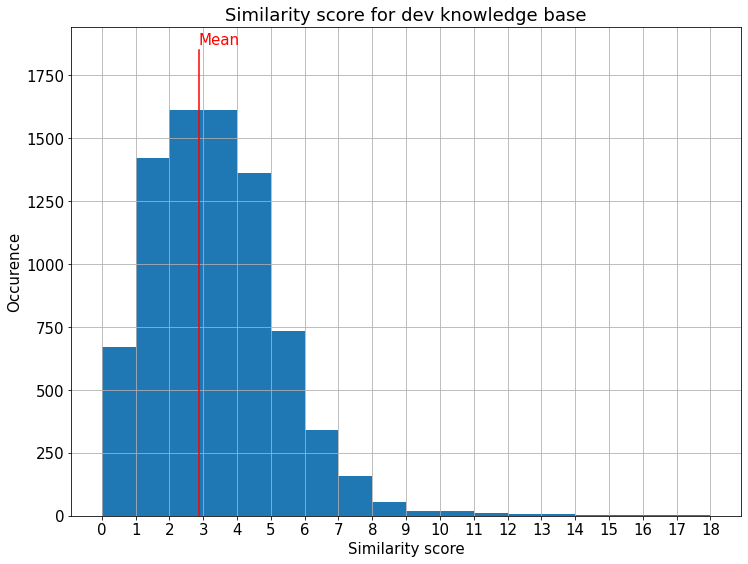

In [124]:
plt.figure(figsize=(12,9))
mean_sim = sum(Sim)/len(Sim)
plt.hist(Sim, bins=range(19))
plt.text(mean_sim, 1870, 'Mean', color='r')
plt.plot([mean_sim, mean_sim], [0, 1850], color='r')
plt.ylabel('Occurence')
plt.xticks(range(19))
plt.title('Similarity score for dev knowledge base')
plt.grid()
plt.xlabel('Similarity score')
plt.show()

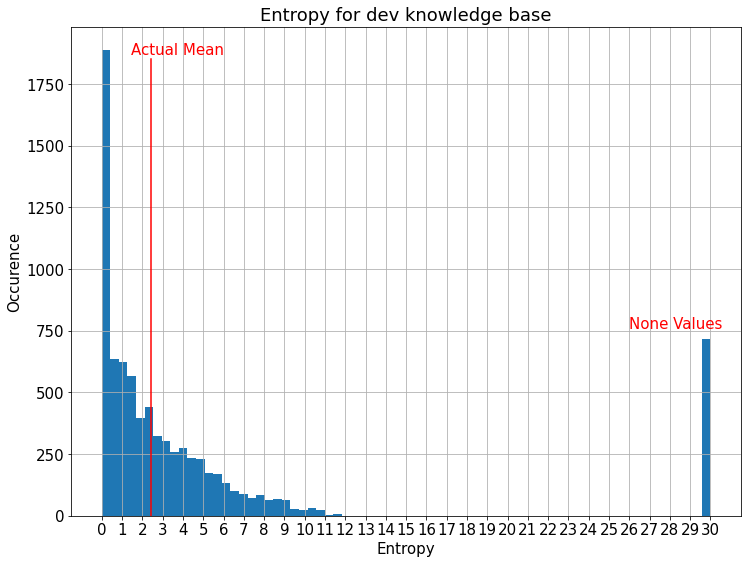

In [ ]:
filtered_Entrop = [e for e in Entrop if e<30]
plt.figure(figsize=(12,9))
mean_Entrop = sum(filtered_Entrop)/len(filtered_Entrop)
plt.hist(Entrop, bins='auto')
plt.text(mean_Entrop-1, 1870, 'Actual Mean', color='r')
plt.text(26, 760, 'None Values', color='r')
plt.plot([mean_Entrop, mean_Entrop], [0, 1850], color='r')
plt.xticks(range(31))
plt.title('Entropy for dev knowledge base')
plt.ylabel('Occurence')
plt.xlabel('Entropy')
plt.grid()
plt.show()
#Note : this visualization is not the right one (core disconected before runing)

# Evaluate on test

In [ ]:
def evaluate_on_test_s():
    """
    evaluate your model on the development dataset.
    In the development dataset, each entity name (suffix) is readable.
    :return:
    """

    # load YAGO knowledge base
    # example: kb.facts["<Babilonia>"]
    kb = KnowledgeBase(test_kb_file)
    count_NONE, count = 0, 0
    dico = {}
    # predict each record and generate dev_results.tsv file
    with open(test_result_file, 'w', encoding="utf-8") as output:
        for page in Parsy(wikipedia_file):
            result, best_sim, entrop = disambiguate_s(page.label(), page.content, kb)
            dico[page.title] = [result, best_sim, entrop]
            if result is None : count_NONE+=1
            if result is not None:
                output.write(page.title+"\t"+result+"\n")
                count +=1

    # evaluate
    evaluate(test_result_file, test_gold_file)
    print(count_NONE)
    print(count)
    return dico

In [ ]:
dico = evaluate_on_test_s()

Streaming output truncated to the last 5000 lines.
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Douglas McArthur
Douglas Francis "Doug" McArthur is an educator and former political figure in Saskatchewan, Canada.
best_poss:  <Douglas_Francis_McArthur_1079001> ; best_sim:  3 ; entrop:  0.5270653410031617
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Saint-Joachim
Saint-Joachim-de-Shefford is a municipality in the Canadian province of Quebec, located within La Haute-Yamaska Regional County Municipality.
best_poss:  None ; best_sim:  0 ; entrop:  30
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Saint-Joachim
Saint-Joachim is a commune in the Loire-Atlantique department in western France.
best_poss:  None ; best_sim:  0 ; entrop:  30
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [ ]:
Sim = [v[1] for v in list(dico.values())]
Entrop = [v[2] for v in list(dico.values())]

Sim.sort()
Entrop.sort()

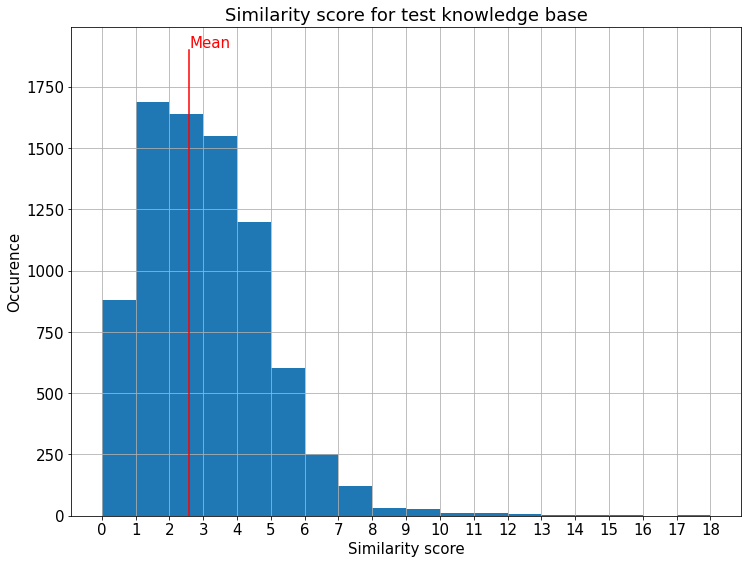

In [ ]:
plt.figure(figsize=(12,9))
mean_sim = sum(Sim)/len(Sim)
plt.hist(Sim, bins=range(19))
plt.text(mean_sim, 1910, 'Mean', color='r')
plt.plot([mean_sim, mean_sim], [0, 1900], color='r')
plt.title('Similarity score for test knowledge base')
plt.ylabel('Occurence')
plt.xticks(range(19))
plt.grid()
plt.xlabel('Similarity score')
plt.show()

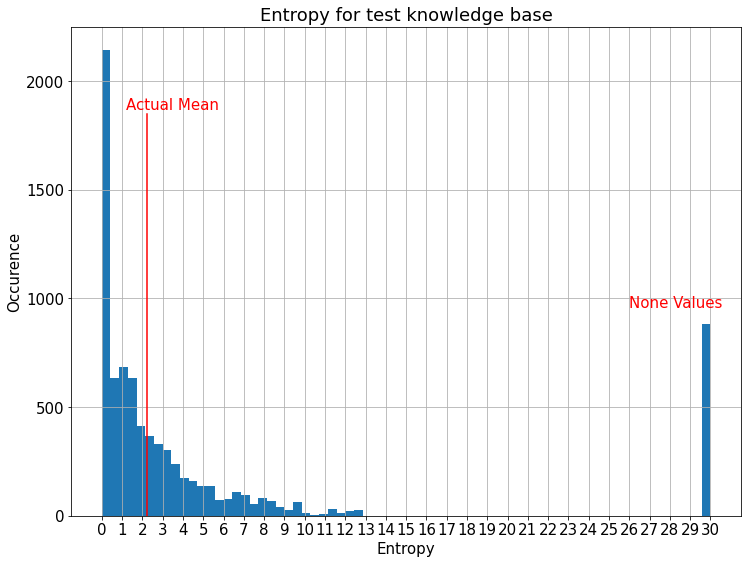

In [ ]:
filtered_Entrop = [e for e in Entrop if e<30]
plt.figure(figsize=(12,9))
mean_Entrop = sum(filtered_Entrop)/len(filtered_Entrop)
plt.hist(Entrop, bins='auto')
plt.text(mean_Entrop-1, 1870, 'Actual Mean', color='r')
plt.text(26, 960, 'None Values', color='r')
plt.plot([mean_Entrop, mean_Entrop], [0, 1850], color='r')
plt.title('Entropy for test knowledge base')
plt.xticks(range(31))
plt.ylabel('Occurence')
plt.xlabel('Entropy')
plt.grid()
plt.show()